<ipython-input-1-fb05bcc41e4b>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_processed.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.892e+08, tolerance: 3.874e+07
  model = cd_fast.enet_coordinate_descent(


Training set size: 1530
Test set size: 383

--- Model Evaluation (Lasso Regression) ---
Training RMSE: $1114.50
Training MAE: $505.35
Training R-squared: 0.9951
Training MAPE: 2.47%

Test RMSE: $2110.96
Test MAE: $1499.88
Test R-squared: 0.9824
Test MAPE: 1.95%

Feature Coefficients (Lasso):
Close_Lag_1              14984.404748
Open_Lag_1                1799.135590
Close_Lag_14              1500.238600
Close_Lag_7               1433.759772
Close_Lag_3                766.741361
Close_Rolling_Mean_30      474.193134
Close_Rolling_Mean_7       461.111531
Close_Lag_30               -68.929593
Open_Rolling_Mean_30      -142.096858
Open_Lag_30               -180.439844
Open_Lag_7                -688.068269
Open_Lag_3                -902.996135
Open_Lag_14              -1225.246985
Open_Rolling_Mean_7      -2344.983102
dtype: float64
Intercept: 21680.9304
Number of features used (non-zero coefficients): 14
Number of features dropped (zero coefficients): 0


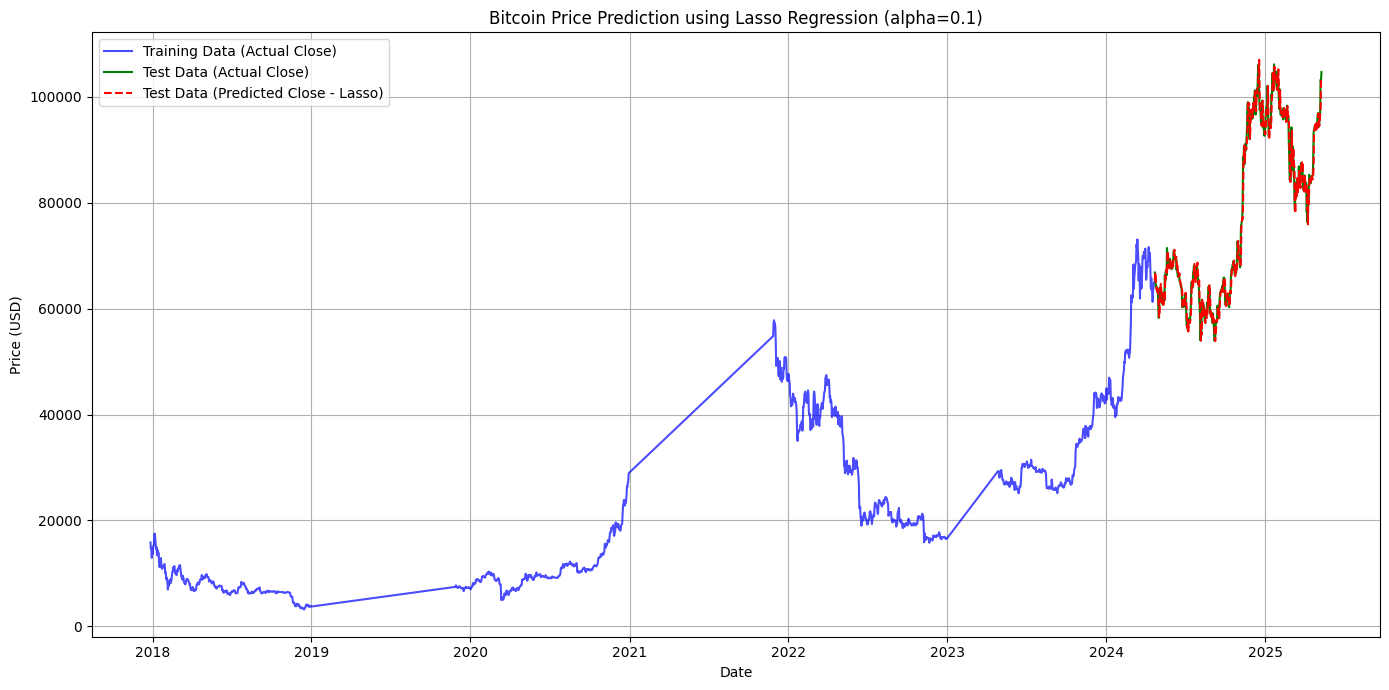


--- Next Day Forecast (1-step ahead using Lasso) ---
Last actual Close on 2025-05-10: $104696.33
Last actual Open on 2025-05-10: $102973.71

Original Features for predicting Close on 2025-05-11:
  Close_Lag_1: 104696.33
  Close_Lag_3: 103241.46
  Close_Lag_7: 94315.97
  Close_Lag_14: 93754.85
  Close_Lag_30: 83404.84
  Close_Rolling_Mean_7: 99115.35
  Close_Rolling_Mean_30: 92083.50
  Open_Lag_1: 102973.71
  Open_Lag_3: 97034.25
  Open_Lag_7: 95877.18
  Open_Lag_14: 94660.91
  Open_Lag_30: 79625.05
  Open_Rolling_Mean_7: 97856.06
  Open_Rolling_Mean_30: 91247.91

Predicted Close for 2025-05-11: $104978.42


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
# from sklearn.model_selection import LassoCV, TimeSeriesSplit # For advanced alpha optimization

# 1. Load the data
try:
    # Make sure to upload 'Bitcoin.csv' to your Colab environment or provide the correct path
    df = pd.read_csv('Bitcoin.csv', delimiter=';')
except FileNotFoundError:
    print("Error: Bitcoin.csv not found. Please ensure the file is in the current directory or provide the correct path.")
    exit()

# 2. Preprocessing
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Assuming DD/MM/YYYY format based on typical CSVs
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Select relevant columns and handle missing values
df_processed = df[['Close', 'Open']].copy()
# Convert to numeric, coercing errors (like commas as decimal separators)
for col in ['Close', 'Open']:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].str.replace(',', '.', regex=False).astype(float)

df_processed.fillna(method='ffill', inplace=True)
df_processed.fillna(method='bfill', inplace=True) # Handle NaNs at the beginning if any

# 3. Feature Engineering
target_col = 'Close'
lags = [1, 3, 7, 14, 30]
rolling_windows = [7, 30]

for lag in lags:
    df_processed[f'Close_Lag_{lag}'] = df_processed[target_col].shift(lag)
for window in rolling_windows:
    df_processed[f'Close_Rolling_Mean_{window}'] = df_processed[target_col].rolling(window=window, min_periods=1).mean().shift(1)

for lag in lags:
    df_processed[f'Open_Lag_{lag}'] = df_processed['Open'].shift(lag)
for window in rolling_windows:
    df_processed[f'Open_Rolling_Mean_{window}'] = df_processed['Open'].rolling(window=window, min_periods=1).mean().shift(1)

df_processed.dropna(inplace=True)

feature_names = [
    f'Close_Lag_{lag}' for lag in lags
] + [
    f'Close_Rolling_Mean_{window}' for window in rolling_windows
] + [
    f'Open_Lag_{lag}' for lag in lags
] + [
    f'Open_Rolling_Mean_{window}' for window in rolling_windows
]

X = df_processed[feature_names]
y = df_processed[target_col]

if X.empty or y.empty:
    print("Not enough data to create features and target after processing.")
    exit()

# 4. Split data chronologically
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train_orig = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test_orig = X.iloc[split_index:]
y_test = y.iloc[split_index:]

print(f"Training set size: {len(X_train_orig)}")
print(f"Test set size: {len(X_test_orig)}")

if len(X_train_orig) == 0 or len(X_test_orig) == 0:
    print("Training or test set is empty.")
    exit()

# 5. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)

X_train = pd.DataFrame(X_train_scaled, columns=X_train_orig.columns, index=X_train_orig.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_orig.columns, index=X_test_orig.index)

# 6. Train the Lasso Regression model
alpha_value = 0.1
model = Lasso(alpha=alpha_value, max_iter=10000)
model.fit(X_train, y_train)

# 7. Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("\n--- Model Evaluation (Lasso Regression) ---")
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
print(f"Training RMSE: ${rmse_train:.2f}")
print(f"Training MAE: ${mae_train:.2f}")
print(f"Training R-squared: {r2_train:.4f}")
print(f"Training MAPE: {mape_train:.2f}%")

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
print(f"\nTest RMSE: ${rmse_test:.2f}")
print(f"Test MAE: ${mae_test:.2f}")
print(f"Test R-squared: {r2_test:.4f}")
print(f"Test MAPE: {mape_test:.2f}%")

coefficients = pd.Series(model.coef_, index=feature_names).sort_values(ascending=False)
print("\nFeature Coefficients (Lasso):")
print(coefficients[coefficients != 0]) # Show only non-zero coefficients
print(f"Intercept: {model.intercept_:.4f}")

# 8. Visualize predictions (Optional, can be commented out if not needed for this specific task)
# plt.figure(figsize=(14, 7))
# plt.plot(y_train.index, y_train, label='Training Data (Actual Close)', color='blue', alpha=0.7)
# plt.plot(y_test.index, y_test, label='Test Data (Actual Close)', color='green')
# plt.plot(X_test.index, y_pred_test, label='Test Data (Predicted Close - Lasso)', color='red', linestyle='--')
# plt.title(f'Bitcoin Price Prediction using Lasso Regression (alpha={alpha_value})')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# 9. Function to predict for a specific future date
def predict_future_date(target_date_str, model, scaler, historical_data, feature_names, lags, rolling_windows, target_col='Close'):
    """
    Predicts the Close price for a specific future date by iteratively forecasting.

    Args:
        target_date_str (str): The target date in 'YYYY-MM-DD' format.
        model: The trained regression model.
        scaler: The fitted StandardScaler.
        historical_data (pd.DataFrame): DataFrame with 'Date' index and 'Close', 'Open' columns,
                                        and pre-calculated lag/rolling features up to the last known date.
        feature_names (list): List of feature column names.
        lags (list): List of lag values used for features.
        rolling_windows (list): List of rolling window sizes used for features.
        target_col (str): Name of the target column (e.g., 'Close').

    Returns:
        float: Predicted Close price for the target_date.
        pd.DataFrame: DataFrame containing historical and all intermediate predicted values.
    """
    try:
        target_date = pd.to_datetime(target_date_str)
    except ValueError:
        print("Invalid date format. Please use YYYY-MM-DD.")
        return None, None

    last_known_date = historical_data.index[-1]
    if target_date <= last_known_date:
        print(f"Target date {target_date.date()} is not in the future or is the last known date.")
        # If the date is in historical_data, we could return the actual or test prediction
        if target_date in historical_data.index:
             print(f"Actual Close on {target_date.date()}: ${historical_data.loc[target_date, target_col]:.2f}")
             if target_date in y_test.index: # Check if it was part of test set
                 idx_in_test = y_test.index.get_loc(target_date)
                 print(f"Model's prediction for {target_date.date()} (from test set): ${y_pred_test[idx_in_test]:.2f}")
        return None, None # Or handle differently

    # Create a copy of historical data to append predictions
    # We only need 'Close' and 'Open' for generating future features
    current_data = historical_data[[target_col, 'Open']].copy()
    
    num_days_to_predict = (target_date - last_known_date).days
    print(f"\nPredicting for {target_date.date()}, which is {num_days_to_predict} day(s) from {last_known_date.date()}.")
    print("Iterative forecasting steps:")

    for i in range(num_days_to_predict):
        current_prediction_date = last_known_date + pd.Timedelta(days=i + 1)
        
        # Prepare features for current_prediction_date using data in current_data
        next_day_feature_values = {}
        
        # Use .iloc[-k] on current_data's 'Close' and 'Open' columns
        # These columns now contain actuals + previous predictions
        
        # Close Lags and Rolling Means
        for lag in lags:
            if len(current_data[target_col]) >= lag:
                next_day_feature_values[f'Close_Lag_{lag}'] = current_data[target_col].iloc[-lag]
            else: # Should not happen if lags are smaller than initial df_processed length
                print(f"Warning: Not enough data for Close_Lag_{lag} on {current_prediction_date.date()}")
                next_day_feature_values[f'Close_Lag_{lag}'] = current_data[target_col].iloc[-1] # Fallback

        for window in rolling_windows:
            if len(current_data[target_col]) >= window:
                next_day_feature_values[f'Close_Rolling_Mean_{window}'] = current_data[target_col].iloc[-window:].mean()
            else: # Use available data if less than window size
                next_day_feature_values[f'Close_Rolling_Mean_{window}'] = current_data[target_col].iloc[:].mean()


        # Open Lags and Rolling Means
        for lag in lags:
            if len(current_data['Open']) >= lag:
                next_day_feature_values[f'Open_Lag_{lag}'] = current_data['Open'].iloc[-lag]
            else:
                print(f"Warning: Not enough data for Open_Lag_{lag} on {current_prediction_date.date()}")
                next_day_feature_values[f'Open_Lag_{lag}'] = current_data['Open'].iloc[-1] # Fallback
                
        for window in rolling_windows:
            if len(current_data['Open']) >= window:
                next_day_feature_values[f'Open_Rolling_Mean_{window}'] = current_data['Open'].iloc[-window:].mean()
            else:
                next_day_feature_values[f'Open_Rolling_Mean_{window}'] = current_data['Open'].iloc[:].mean()

        # Create DataFrame for the single day's features, ensuring correct column order
        next_day_features_df_orig = pd.DataFrame([next_day_feature_values], columns=feature_names)
        
        # Scale features
        next_day_features_scaled = scaler.transform(next_day_features_df_orig)
        
        # Predict
        prediction = model.predict(next_day_features_scaled)[0]
        
        print(f"  Predicted Close for {current_prediction_date.date()}: ${prediction:.2f}")

        # Add prediction to current_data for next iteration's feature calculation
        # Assumption: Next day's Open is the current day's predicted Close
        new_row = pd.DataFrame({target_col: [prediction], 'Open': [prediction]}, index=[current_prediction_date])
        current_data = pd.concat([current_data, new_row])

        if current_prediction_date == target_date:
            return prediction, current_data # Return the final prediction and the extended data

    return None, current_data # Should be caught by the loop's return

# --- Main part for user input ---
if __name__ == "__main__":
    # Use df_processed as the base historical data for predictions
    # It already contains all necessary columns and has NaNs dropped
    
    # Make a 1-step forecast (for the day after the last data point in df_processed)
    # This is similar to the original code's section 9, but using the new function
    last_actual_date_in_df = df_processed.index[-1]
    next_day_after_data = (last_actual_date_in_df + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
    
    print(f"\n--- Example: Predicting for {next_day_after_data} (1 day after last data point) ---")
    predicted_price_next_day, _ = predict_future_date(
        next_day_after_data,
        model,
        scaler,
        df_processed, # Pass the full df_processed which includes original features
        feature_names,
        lags,
        rolling_windows
    )
    if predicted_price_next_day is not None:
        print(f"Final Predicted Close for {next_day_after_data}: ${predicted_price_next_day:.2f}")

    print("\n--- Predict for a user-specified future date ---")
    while True:
        user_date_str = input("Enter the date you want to predict for (YYYY-MM-DD), or 'quit' to exit: ")
        if user_date_str.lower() == 'quit':
            break
        
        predicted_price, extended_data = predict_future_date(
            user_date_str,
            model,
            scaler,
            df_processed, # Base historical data
            feature_names,
            lags,
            rolling_windows
        )
        
        if predicted_price is not None:
            print(f"\n>>> Final Predicted Close for {user_date_str}: ${predicted_price:.2f}")
            # You can optionally plot extended_data here if you want to see the forecast trajectory
            # plt.figure(figsize=(10,5))
            # extended_data['Close'].plot(label='Historical + Forecasted Close')
            # plt.title(f'Bitcoin Price Forecast up to {user_date_str}')
            # plt.ylabel('Price (USD)')
            # plt.legend()
            # plt.grid(True)
            # plt.show()
        else:
            print(f"Could not generate a prediction for {user_date_str}.")